# Ecuación de Helmholtz, proyecto final.

La frontera está dada por:

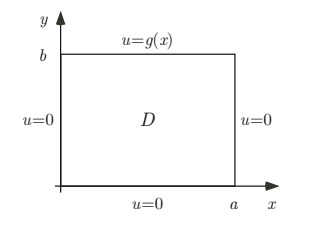

Con a=b=1.

In [ ]:
# Librerias.
import math as mt
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import sympy as sp
from mpl_toolkits.mplot3d import Axes3D

# Discretización.
N=40
M=N
w=-2 # Valor w.
X=np.linspace(0,1,N+1)
Y=np.linspace(0,1,M+1)
k=(1-0)/M
h=(1-0)/N
l=k/h

# Función de frontera.
def g(x): return np.sin(3*mt.pi*x)

# Matriz -A.
A=np.zeros((N*M,N*M))
for i in range(N*M): # Diagonal.
  A[i,i]=4-w*(h**2)
for i in range(N*M-1): # Subdiagonales.
  A[i,i+1]=-1
  A[i+1,i]=-1
for i in range(N,N*M): # Superdiagonal.
  A[i,i-N]=-1
for i in range(N*M-N): # Superdiagonal.
  A[i,i+N]=-1
for i in range(N,N*M,N):
  A[i,i-1]=0
  A[i-1,i]=0

# Matriz -b.
b=np.zeros((N*M,1))
for i in range(N*M-N,N*M):
  b[i,0]=-g(X[i-(N*M-N)])

## Solución real.

Está dada por:

In [ ]:
def l_n(n): return np.pi*n # Lambda_n
def g_n(n): return np.sqrt((l_n(n)**2)-w) # Gamma_n
def f(x,n): return 2*np.sin(3*np.pi*x)*np.sin(l_n(n)*x) # Función integrable.

In [ ]:
# Renovamos la discretización.
X=np.linspace(0,1,N+1)
Y=np.linspace(0,1,M+1)
# Calculamos las parejas (x,y).
Val=[(c, p) for p in Y[1::] for c in X[1::]]
X=np.array([i[0] for i in Val])
Y=np.array([i[1] for i in Val])

In [ ]:
# Calculamos la solución analítica.
sol=np.zeros((N*M))
for i in range(1,150): # La sumatoria aproximada hasta n=150.
  a_n=sc.integrate.quad(f,0,1,args=(i,)) # El termino a_n.
  t_n=(a_n[0]/np.sinh(g_n(i)))*np.sinh(g_n(i)*Y)*np.sin(l_n(i)*X) # El término n-ésimo de la sumatoria.
  t_n=np.array(t_n)
  sol=sol+t_n # Sumamos.

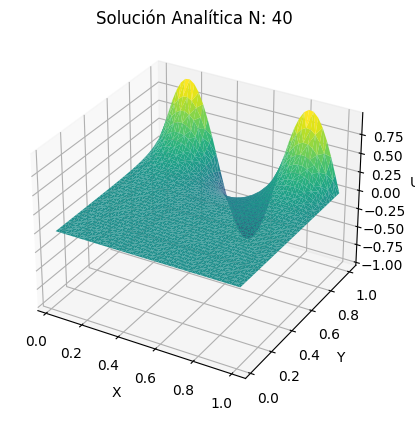

In [ ]:
# Graficar la solución analítica:
def graficar_analitica():
  fig = plt.figure()
  ax = plt.axes(projection='3d')
  surface = ax.plot_trisurf(X,Y,sol, cmap='viridis')
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel("U")
  ax.title.set_text(f"Solución Analítica N: {N}")
  plt.show()
graficar_analitica()

## Solución aproximada por CGM.

In [ ]:
# Inicializar las variables

xi = np.ones((N*N,1))  # Vector inicial xi con N*N elementos, vector unidimensional
ri = b - np.dot(A, xi)  # Residuo inicial
di = ri.copy()  # Dirección inicial, misma dimensión que ri
error = 10**(-4)  # Tolerancia del error

for _ in range(1000):  # Número máximo de iteraciones

    qk = np.dot(A, di)  # Aplicar la matriz A a di
    alphai = np.dot(ri.T, ri) / np.dot(di.T, qk)

    xi_new = xi + alphai * di  # Actualizar xi.

    ri_new = ri - alphai * qk  # Actualizar ri.

    # Verificar convergencia.
    if np.linalg.norm(ri_new) < error: # Verificar el error.
        print(f"Convergencia alcanzada: {_} iteraciones.") # Muestra las iteraciones.
        break

    betai = np.dot(ri_new.T, ri_new) / np.dot(ri.T, ri)

    di = ri_new + betai * di  # Actualizar di.

    # Actualizar xi y ri para la siguiente iteración
    xi = xi_new
    ri = ri_new

Convergencia alcanzada: 82 iteraciones.


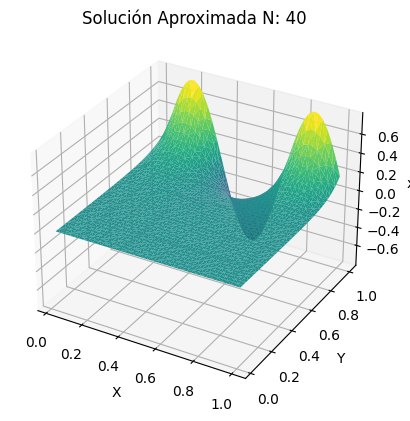

In [ ]:
def graficar_CGM():
  global xi
  fig = plt.figure()
  ax = plt.axes(projection='3d')
  xi=xi.reshape(N*N)
  surface = ax.plot_trisurf(X,Y,-xi, cmap='viridis')
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel("x1")
  ax.title.set_text(f"Solución Aproximada N: {N}")
  plt.show()
graficar_CGM()

## Estudio del error:

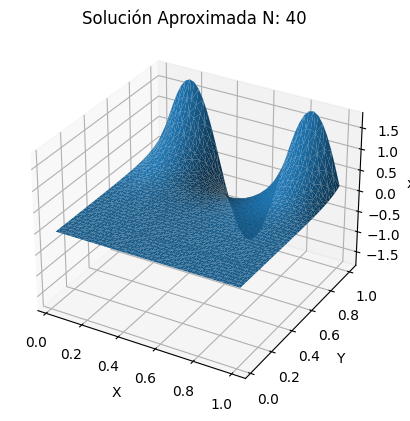

In [ ]:
# Grafica del error.
error=np.array(sol-xi) # Calcular el error.
# Graficar.
fig = plt.figure()
ax = plt.axes(projection='3d')
surface = ax.plot_trisurf(X,Y,error)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel("x1")
ax.title.set_text(f"Solución Aproximada N: {N}")
plt.show()

In [ ]:
# Error máximo.
error=np.linalg.norm(sol+xi,np.inf)
error

0.29736419357613875

## Solución aproximada con PCGM.

Jacobi Preconditioner: M será la diagonal de A.

In [ ]:
Mat = np.diag(np.diag(A))
M_inv = sc.linalg.inv(Mat)  # Calcula el inverso de M

# Inicializar las variables
xi_PCGM = np.ones((N*N,1))  # Vector inicial xi con N*N elementos, vector unidimensional
ri = b - np.dot(A, xi_PCGM)  # Residuo inicial
zi = M_inv.dot(ri)  # Aplicar el precondicionador al residuo
di = zi.copy()  # Dirección inicial
error = 10**(-4)  # Tolerancia del error

# Iteración del método PCGM
for _ in range(1000):  # Número máximo de iteraciones
    qk = np.dot(A, di)
    alphai = np.dot(ri.T, zi) / np.dot(di.T, qk)

    xi_new = xi_PCGM + alphai * di
    ri_new = ri - alphai * qk

    if np.linalg.norm(ri_new) < error:
        print(f"Convergencia alcanzada en la iteración: {_}")
        break

    zi_new = M_inv.dot(ri_new)  # Aplicar el precondicionador al nuevo residuo
    betai = np.dot(ri_new.T, zi_new) / np.dot(ri.T, zi)

    di = zi_new + betai * di

    # Actualizar xi, ri y zi para la siguiente iteración
    xi_PCGM = xi_new
    ri = ri_new
    zi = zi_new

Convergencia alcanzada en la iteración: 82


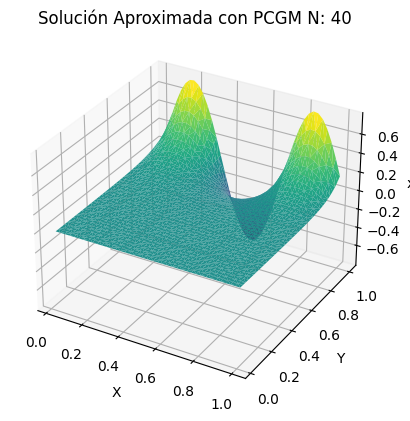

In [ ]:
def graficar_PCGM():
  global xi_PCGM
  fig = plt.figure()
  ax = plt.axes(projection='3d')
  xi_PCGM=xi_PCGM.reshape(N*N)
  surface = ax.plot_trisurf(X,Y,-xi_PCGM, cmap='viridis')
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel("x1")
  ax.title.set_text(f"Solución Aproximada con PCGM N: {N}")
  plt.show()
graficar_PCGM()

Precondicionador de Gauss-Seidel: Este divide la matriz A en una matriz triangular inferior L, una matriz diagonal D, y una matriz triangular superior U.

El precondicionador se define como: M=(D+L) donde D es la parte diagonal de A y L es la parte triangular inferior.

In [ ]:
# Precondicionador de Gauss-Seidel
D = np.diag(np.diag(A))
L = np.tril(A) - D
M = D + L
M_inv = np.linalg.inv(M)  # Inverso del precondicionador de Gauss-Seidel

# Inicializar las variables
xi = np.ones((N*N,1))  # Vector inicial xi con N*N elementos, vector unidimensional
ri = b - np.dot(A, xi)  # Residuo inicial
zi = np.dot(M_inv, ri)  # Aplicar el precondicionador al residuo
di = zi.copy()  # Dirección inicial
error = 10**(-4)  # Tolerancia del error

# Iteración del método PCGM
for _ in range(1000):  # Número máximo de iteraciones
    qk = np.dot(A, di)
    alphai = np.dot(ri.T, zi) / np.dot(di.T, qk)

    xi_new = xi + alphai * di
    ri_new = ri - alphai * qk

    if np.linalg.norm(ri_new) < error:
        print(f"Convergencia alcanzada en la iteración {_}")
        break

    zi_new = np.dot(M_inv, ri_new)  # Aplicar el precondicionador al nuevo residuo
    betai = np.dot(ri_new.T, zi_new) / np.dot(ri.T, zi)

    di = zi_new + betai * di

    # Actualizar xi, ri y zi para la siguiente iteración
    xi = xi_new
    ri = ri_new
    zi = zi_new
xi_PCGM=xi.copy()

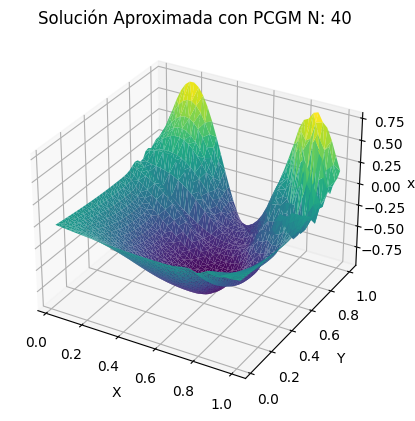

In [ ]:
graficar_PCGM()

Precondicionador Incomplete Cholesky (IC). El precondicionador IC se construye descomponiendo la matriz A de tal manera que $A≈LL^T$ donde L es una matriz triangular inferior y $L^T$ es su transpuesta. Esta aproximación se utiliza en lugar de la matriz completa para ahorrar memoria y cálculos.

In [ ]:
from scipy.sparse.linalg import spilu
from scipy.sparse import csc_matrix

# Convertir A a una matriz dispersa para la factorización IC
A_sparse = csc_matrix(A)

# Precondicionador Incomplete Cholesky
ilu = spilu(A_sparse)  # Incomplete LU factorization
M_inv = lambda x: ilu.solve(x)  # Precondicionador aplicando la factorización ILU

# Inicializar las variables
xi = np.ones((N*N,1))  # Vector inicial xi con N*N elementos, vector unidimensional
ri = b - np.dot(A, xi)  # Residuo inicial
zi = M_inv(ri)  # Aplicar el precondicionador al residuo
di = zi.copy()  # Dirección inicial
error = 10**(-2)  # Tolerancia del error

# Iteración del método PCGM
for _ in range(10000):  # Número máximo de iteraciones
    qk = np.dot(A, di)
    alphai = np.dot(ri.T, zi) / np.dot(di.T, qk)

    xi_new = xi + alphai * di
    ri_new = ri - alphai * qk

    if np.linalg.norm(ri_new) < error:
        print(f"Convergencia alcanzada en la iteración {_}")
        break

    zi_new = M_inv(ri_new)  # Aplicar el precondicionador al nuevo residuo
    betai = np.dot(ri_new.T, zi_new) / np.dot(ri.T, zi)

    di = zi_new + betai * di

    # Actualizar xi, ri y zi para la siguiente iteración
    xi = xi_new
    ri = ri_new
    zi = zi_new

xi_PCGM=xi.copy()

Convergencia alcanzada en la iteración 14


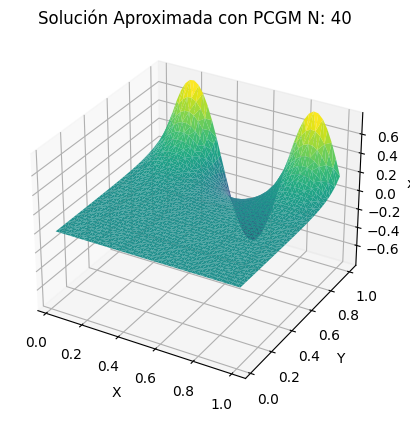

In [ ]:
graficar_PCGM()